In [4]:
from rdkit.Chem.rdmolfiles import MolFromPDBFile
from rdkit.Chem.rdchem import Mol
from rdkit.Chem import AllChem

import numpy as np
import rdkit.Chem as Chem
from rdkit.Chem import AddHs, AssignStereochemistry, HybridizationType, ChiralType, BondStereo, MolFromMol2File
from rdkit.Chem.AllChem import ComputeGasteigerCharges
import os
import sys
sys.path.append("../../")
from src.data.pocket_utils import get_atom_coordinates, find_pocket_atoms_RDKit
from src.utils.constants import ES_THRESHOLD, METAL_OX_STATES, POCKET_THRESHOLD
from tqdm import tqdm 

In [5]:
from src.data.utils import pdb_to_rdkit_mol, mol2_to_rdkit_mol, get_vdw_radius, add_charges_to_molecule, get_node_features, get_edge_features, extract_charges_from_mol2

In [6]:
ligand_mol = mol2_to_rdkit_mol("../../test_data/pdb/1a0q/1a0q_ligand.mol2", sanitize = False) #/Users/tsachmackey/Documents/Summer 2024/Research /Batista project/AffinityNet/test_data/pdb/1a0q
protein_mol = pdb_to_rdkit_mol("../../test_data/pdb/1a0q/1a0q_protein.pdb") #/Users/tsachmackey/Documents/Summer 2024/Research /Batista project/AffinityNet/test_data/pdb/1a0q

complex_mol = Chem.CombineMols(protein_mol, ligand_mol)

In [10]:
def get_centroid(mol):
    conf = mol.GetConformer()
    positions = conf.GetPositions()
    centroid = np.mean(positions, axis=0)
    return centroid

def get_max_distance_from_centroid(mol, centroid):
    conf = mol.GetConformer()
    max_distance = 0.0
    for atom in mol.GetAtoms():
        pos = conf.GetAtomPosition(atom.GetIdx())
        distance = np.linalg.norm(pos - centroid)
        if distance > max_distance:
            max_distance = distance
    return max_distance

def get_atoms_within_distance(mol, centroid, distance, by_residue=False):
    conf = mol.GetConformer()
    atoms_within_distance = set()
    residues_within_distance = set()

    for atom in mol.GetAtoms():
        pos = conf.GetAtomPosition(atom.GetIdx())
        if np.linalg.norm(pos - centroid) <= distance:
            atoms_within_distance.add(atom.GetIdx())
            if by_residue:
                residues_within_distance.add(atom.GetPDBResidueInfo().GetResidueNumber())
    
    if by_residue:
        for atom in mol.GetAtoms():
            if atom.GetPDBResidueInfo().GetResidueNumber() in residues_within_distance:
                atoms_within_distance.add(atom.GetIdx())

    return list(atoms_within_distance)

def tag_atoms(mol, tag):
    for atom in mol.GetAtoms():
        atom.SetProp('protein_or_ligand', tag)

def combine_and_filter(ligand_mol, protein_mol, constant_distance, by_residue=False):
    ligand_centroid = get_centroid(ligand_mol)
    max_ligand_distance = get_max_distance_from_centroid(ligand_mol, ligand_centroid)
    threshold_distance = max_ligand_distance + constant_distance

    atoms_to_include = get_atoms_within_distance(protein_mol, ligand_centroid, threshold_distance, by_residue)
    
    editable_protein_mol = Chem.EditableMol(protein_mol)
    for atom in reversed(range(protein_mol.GetNumAtoms())):
        if atom not in atoms_to_include:
            editable_protein_mol.RemoveAtom(atom)
    
    filtered_protein_mol = editable_protein_mol.GetMol()
    
    # Tag atoms before combining
    tag_atoms(ligand_mol, "ligand")
    tag_atoms(filtered_protein_mol, "protein")
    
    complex_mol = Chem.CombineMols(filtered_protein_mol, ligand_mol)
    
    return complex_mol

def identify_atom_sources(complex_mol):
    atom_sources = []
    for atom in complex_mol.GetAtoms():
        source = atom.GetProp('source')
        atom_sources.append(source)
    return atom_sources

# Example usage:
ligand_mol2_path = '../../test_data/pdb/1a0q/1a0q_ligand.mol2'
protein_pdb_path = '../../test_data/pdb/1a0q/1a0q_protein.pdb'
constant_distance = 5.0  # Example constant distance in angstroms

ligand_mol = mol2_to_rdkit_mol(ligand_mol2_path)
protein_mol = pdb_to_rdkit_mol(protein_pdb_path)

In [11]:
def remove_waters(mol):
    water_residue_names = {"HOH", "WAT"}
    atoms_to_remove = []

    for atom in mol.GetAtoms():
        residue_info = atom.GetPDBResidueInfo()
        if residue_info and residue_info.GetResidueName().strip() in water_residue_names:
            atoms_to_remove.append(atom.GetIdx())
    
    editable_mol = Chem.EditableMol(mol)
    for atom_idx in reversed(atoms_to_remove):
        editable_mol.RemoveAtom(atom_idx)
    
    return editable_mol.GetMol()

In [12]:
# Set by_residue to True to include entire residues
pocket_mol_res = combine_and_filter(ligand_mol, remove_waters(protein_mol), constant_distance, by_residue=True)

# To save the resulting complex_mol to a PDB file:
output_path =  '../../test_data/pdb/1a0q/pocket_mol_res.pdb'
pdb_block = Chem.MolToPDBBlock(pocket_mol_res)

with open(output_path, 'w') as file:
    file.write(pdb_block)


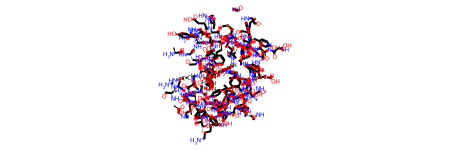

In [13]:
pocket_mol_res


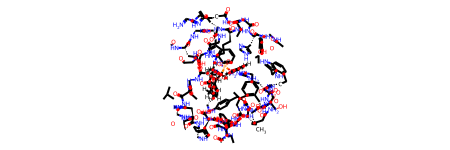

In [14]:
pocket_mol_atom = combine_and_filter(ligand_mol, protein_mol, constant_distance, by_residue=False)
pocket_mol_atom